In [1]:
"""
This program is made to upload the raw json beat detection, from the cadenza parser to dynamodb
"""

import argparse
import json
import os
import os.path
from decimal import Decimal

import boto3


class BeatMapManager():

    def __init__(self):
        
        self.table = None
        self.json_data = None

    def connect_create_table(self):
        """Creates the following the table if it does not exist, and connects to the table"""
        dynamodb = boto3.resource('dynamodb')
        self.table = dynamodb.Table("mappedbeats")

        try:
            self.table.item_count
        except Exception:

            self.table = dynamodb.create_table(
                TableName='mappedbeats',
                KeySchema=[
                    {
                        'AttributeName': "Title",
                        'KeyType': 'HASH'
                    },
                    {
                        'AttributeName': "Artist",
                        'KeyType': 'RANGE'
                    }
                    ],
                AttributeDefinitions=[
                    {
                        'AttributeName': 'Title',
                        'AttributeType': 'S',
                    }, 
                    {
                        'AttributeName': 'Artist',
                        'AttributeType': 'S',
                    }, 
                ],
                ProvisionedThroughput={
                    'ReadCapacityUnits' : 5,
                    'WriteCapacityUnits': 5
                }

            )
            self.table.meta.client.get_waiter('table_exists').wait(TableName='mappedbeats')
        

    def read_in_json(self, file_path):
        """ Path to the json file, returns empty dict if file does not exist
        Parameters
        ----------
            file_path: String
                Path to the file to be uploaded
        """

        if not os.path.exists(file_path):
            return {}

        with open(file_path, "rb") as json_file:
            self.json_data = json.load(json_file, parse_float=Decimal)
    

    def display_data(self):
        """Displays pretty json data"""
        if self.json_data is None:
            print("No data is stored")
            return
        
        print(json.dumps(self.json_data, indent=4, default= lambda x: float(x)))


    def upload_data(self):
        """Uploads the json data to DynamoDB"""

        if self.json_data is None:
            print("No data to upload")
            return
        
        if self.table is None:
            self.connect_create_table()

        Item = {
            "Title" : self.json_data["Title"],
            "Artist" : self.json_data["Artist"],
            "BPM": self.json_data["BPM"],
            "Confidence": self.json_data["Confidence"],
            "Beats": self.json_data["Beats"],
            "Beat_Interval": self.json_data["Beat_Intervals"]
        }

        self.table.put_item(Item=Item)


    def update_item(self, song, artist):
        """Updates the metadata for a given song by an artist
            Parameters
            ----------
            song: String
                Name of the song to filter by
            artist: String
                Name of the artist to filter by
        """

        if self.json_data is None:
            print("no update data provided")
            return
        
        if self.table is None:
            self.connect_create_table()

        
        Item = {
            "Title" : self.json_data["Title"],
            "Artist" : self.json_data["Artist"],
            "BPM": self.json_data["BPM"],
            "Confidence": self.json_data["Confidence"],
            "Beats": self.json_data["Beats"],
            "Beat_Interval": self.json_data["Beat_Intervals"]
        }


        self.table.update_item(
            Key = {
                "Title": song,
                "Artist": artist
            },
            UpdateExpression="SET Beats = :val1, Confidence = :val2, BPM = :val3, Beat_Interval = :val4",
            ExpressionAttributeValues={
                ':val1': self.json_data["Beats"],
                ':val2': self.json_data["Confidence"],
                ':val3': self.json_data["BPM"],
                ':val4': self.json_data["Beat_Intervals"]
            }
        )
        

    def delete(self, song, artist):
        """Deletes a song from the beatmap database
            Parameters
            ----------
            song: String
                Name of the song to filter by
            artist: String
                Name of the artist to filter by
        """

        self.table.delete_item(
            Key = {
                "Title": song,
                "Artist": artist
            })
        

    def get_item(self, song, artist):
        """Retrieves the beatmap for a given song/artist
         song: String
                Name of the song to filter by
            artist: String
                Name of the artist to filter by
        """
        

        response = self.table.get_item(


            Key={
                'Artist': artist,
                'Title': song
            }
        )

        return response["Item"]



def main(ipArgs = None):

    parser = argparse.ArgumentParser(description=__doc__)
    parser.add_argument("--json-path", '-j' , help="A path to a json file")
    parser.add_argument("--create", '-c', help="Create the table for the beat maps", action='store_true')
    parser.add_argument("--insert", '-i', help="Insert a new beatmap", action='store_true')
    parser.add_argument("--update", "-u", help="Update a given beat map", action='store_true')
    parser.add_argument("--delete", "-d", help="Delete a given beat map", action='store_true')
    parser.add_argument("--get", "-g", help="Retreive a given beat map", action='store_true')
    parser.add_argument("--artist", "-a", help="Name of artist")
    parser.add_argument("--song", "-s",  help="Name of song")
    
    args = None
    if ipArgs is None:
        args = parser.parse_args()
    else:
        args = parser.parse_args(ipArgs)

    if args.create:
        upldr = BeatMapManager()
        upldr.connect_create_table()
        return


    if args.insert:
        if args.json_path is None:
            print("No file path provided")
            return

        upldr = BeatMapManager()
        upldr.read_in_json(args.json_path)
        upldr.upload_data()
        return


    if args.artist is None or args.song is None:
        print("No song or artist provided")
        return

    if args.update:
        if args.json_path is None:
            print("No file path provided")
            return
        mgr = BeatMapManager()
        mgr.connect_create_table()
        mgr.read_in_json(args.json_path)
        mgr.update_item(args.song, args.artist)

    if args.delete:
        mgr = BeatMapManager()
        mgr.connect_create_table()
        mgr.delete(args.song, args.artist)
    
    if args.get:
        mgr = BeatMapManager()
        mgr.connect_create_table()
        item = mgr.get_item(args.song, args.artist)
        print(item)

        
    


In [2]:
args = ["-g", "-a", "Tristam & Brakem", "-s", "Flight"]
main(ipArgs=args)

{'Confidence': Decimal('2.295747756958008'), 'Title': 'Flight', 'Beats': [Decimal('0.6501587'), Decimal('1.3235373'), Decimal('1.9969161'), Decimal('2.6470747'), Decimal('3.2624035'), Decimal('3.8893423'), Decimal('4.5046711'), Decimal('5.1199999'), Decimal('5.7237186'), Decimal('6.3158274'), Decimal('6.9079366'), Decimal('7.5232654'), Decimal('8.1269836'), Decimal('8.7307024'), Decimal('9.3808613'), Decimal('10.0078'), Decimal('10.611519'), Decimal('11.215238'), Decimal('11.807346'), Decimal('12.399456'), Decimal('12.991565'), Decimal('13.606894'), Decimal('14.233832'), Decimal('14.860771'), Decimal('15.476099'), Decimal('16.091429'), Decimal('16.695147'), Decimal('17.287256'), Decimal('17.879364'), Decimal('18.483084'), Decimal('19.098412'), Decimal('19.702131'), Decimal('20.340679'), Decimal('21.048889'), Decimal('21.745487'), Decimal('22.442085'), Decimal('23.150295'), Decimal('23.870113'), Decimal('24.578321'), Decimal('25.29814'), Decimal('26.00635'), Decimal('26.702948'), Decima

In [3]:
args = ["-i", "-j", "JSON/TryThis.json"]
main(ipArgs=args)

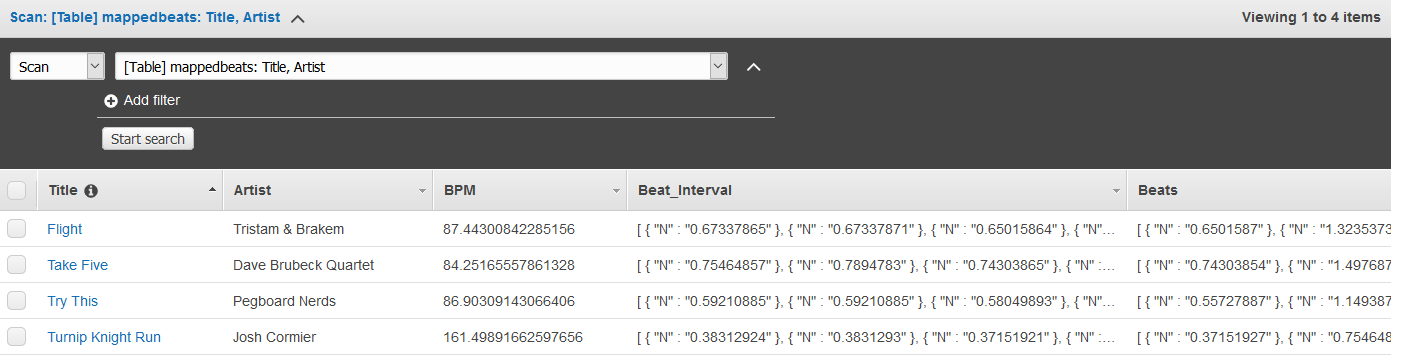

In [4]:
args = ["-d", "-a", "Dave Brubeck Quartet", "-s", "Take Five"]
main(ipArgs=args)

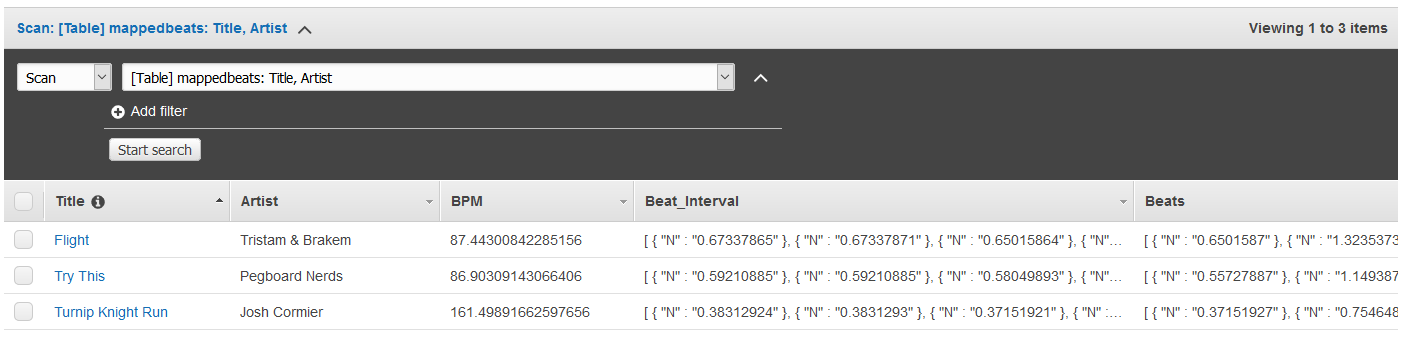

<p>The Flight.json file has the bpm messed up, and a fair portion of the beats removed. There will always be one more beat than beat intervals because the intervals are found by the difference of detected beats.</p>

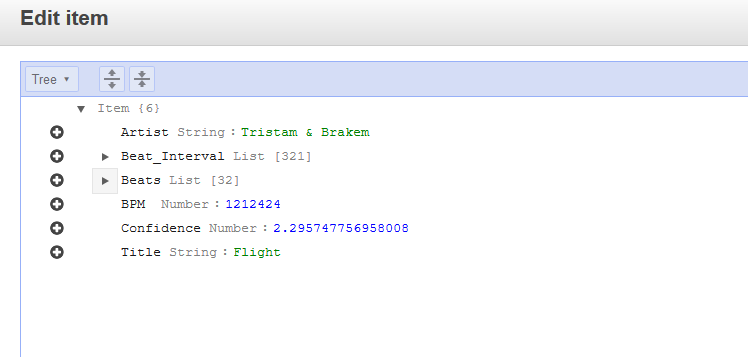

In [8]:
args = ["-u", "-j", "JSON/Flight-Fixed.json", "-a", "Tristam & Brakem", "-s", "Flight"]
main(ipArgs=args)

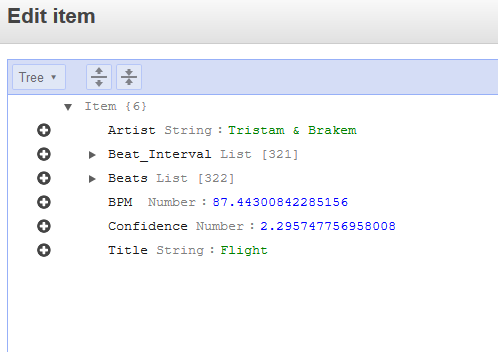